In [9]:
import numpy as np
import pygame
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from lmfit import Model

## Simulação

In [10]:
def simulacao(NUM_ATOMS, RAIO, MASSA, RAIOB, MASSAB, DELTAt, VELOCIDADE):

    # Inicialização do pygame
    pygame.init()
    
    num_atoms = NUM_ATOMS
    raio = RAIO
    massa = MASSA
    raioB = RAIOB
    massaB = MASSAB
    dt = DELTAt
    v_inicial = VELOCIDADE
    
    # Parâmetros
    vx_inicial = v_inicial
    vy_inicial = v_inicial
    temperatura = 8 # em Kelvin

    # Parâmetros da janela
    width, height = 800, 600
    window = pygame.display.set_mode((width, height))
    pygame.display.set_caption("Simulação da Colisão Elástica")

    # Cores
    white = (255, 255, 255)
    red = (255, 0, 0)
    azul = (0, 0, 255)
    color = red
    ### Preciso definir as bolinhas, quem são e como serão representadas

    ## Tem uma velocidade no eixo x, velocidade no eixo y, posição inicial em x e posição inicial em y

    ## Vamos fazer a representação das bolinhas utilizando matrizes do numpy, preenchida com zeros e 1, sendo 1 a representação dela
    class atomo:
        """Essa classe irá representar os nossos átomos,
        Terá a posição inicial deles, sua velocidade em x e y, e o seu raio."""
        def __init__(self, tipo, x,y, raio, temperatura, massa, vx_inicial, vy_inicial, syles=None):
            '''definindo como que cada parâmetro irá se inicializar'''
            #Para gerar os valores aleatórios vamos utilizar uma função do numpy chamda random uniform que gera valores aleatórios seguindo 
            ## um intervalo de valores específicado
            self.reatividade = False
            self.tipo = tipo
            self.p = np.array((x,y)) #defino a posição das bolinhas
            vx = random.randint(-vx_inicial, vx_inicial)
            vy = random.randint(-vy_inicial, vy_inicial)
            self.v = np.array((vx,vy))
            self.caract = np.array((temperatura,massa,raio)) #Definindo características das bolinhas
        # Movimento das bolinhas
        def movimento(self, dt):

            self.p = self.p + self.v*dt

            #Restringir a região das bolinhas

            self.p[0] = max(self.caract[2], min(self.p[0], width - self.caract[2]))
            self.p[1] = max(self.caract[2], min(self.p[1], height - self.caract[2]))
        #Verificando se há colisão entre elas
        def verifica_colisao(self,b2):
            distance = math.sqrt((self.p[0] - b2.p[0])**2 + (self.p[1] - b2.p[1])**2)
            return distance <= self.caract[2] + b2.caract[2]


        def aplica_colisao(self,b2):
            dx = b2.p[0] - self.p[0]
            dy = b2.p[1] - self.p[1]
            distancia = math.sqrt(dx**2 + dy**2)
            dx_futuro = (b2.p[0] + b2.v[0]) - (self.p[0] + self.v[0])
            dy_futuro = (b2.p[1] + b2.v[1]) - (self.p[1] + self.v[1])
            distancia_futura = math.sqrt(dx_futuro**2 + dy_futuro**2)
            if distancia_futura < distancia:
                m1,m2 = 4e-23, 4e-23#self.caract[2]**2, b2.caract[2]**2
                M = m1 + m2
                r1,r2 = self.p, b2.p
                d = np.linalg.norm(r1-r2)**2
                v1, v2 = abs(self.v), abs(b2.v)
                u1 = v1 - (2*m2/M *(np.dot(v1-v2,r1-r2)/d)* (r1-r2))
                u2 = v2 - (2*m1/M * (np.dot(v2-v1,r2-r1)/d) * (r2-r1))
                self.v = u1
                b2.v = -u2

        def colisao_parede(self):
                # Refletir a direção da bola quando colide com as paredes
            if (self.p[0] - self.caract[2] <= 0).any(): #and self.v[0] < 0
                self.v[0] = (-self.v[0])          

            if (self.p[0] + self.caract[2] >= width).any(): #and self.v[0] > 0:
                self.v[0] = (-self.v[0])

            if (self.p[1] - self.caract[2] <= 0).any(): #and self.v[1] < 0:
                self.v[1] = (-self.v[1]) 
            if (self.p[1] + self.caract[2] >= height).any(): # and self.v[1] > 0 :
                self.reatividade = True
                self.v[1] = (-self.v[1]) 


    #lista de atomos

    atomos = []
    tipo = "A"

    for _ in range(num_atoms):
        valid_position = False
        while not valid_position:
            x = random.randint(50, width - 50)
            y = random.randint(50, height - 50)
            # Verificar se a posição não está muito próxima de outras posições já escolhidas
            if all(math.sqrt((x-atom.p[0])**2 + (y - atom.p[1])**2) >= 3 * atom.caract[2] for atom in atomos):
                if all(math.sqrt((x - atom.p[0])**2 + (y - atom.p[1])**2) >= 3 * atom.caract[2] for atom in atomos):
                    valid_position = True

        atom = atomo(tipo, x, y, raio, temperatura, massa, vx_inicial, vy_inicial)
        atomos.append(atom)


    # Loop principal
    evolucao = {}
    tempos = []
    concentracoes = []
    running = True
    clock = pygame.time.Clock()
    n = -1
    
    while running:
        n+=1
        color = red
        c_A = 0
        c_B = 0
        
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
        if len(atomos) <= ((num_atoms/2) +0.5):
            running = False

        window.fill(white)

        for atom in atomos:
            atom.movimento(dt)
            atom.colisao_parede()
            if atom.tipo == "A":
                c_A+=1
            if atom.tipo == "B":
                c_B+=1
                color = azul
            pygame.draw.circle(window, color, (int(atom.p[0]), int(atom.p[1])), atom.caract[2])

        # Verificar colisões
        lista_remover = []
        atomos_num = []
        limite = 0.8
        prob = round(random.random(), 1)
        for i in range(len(atomos)):
            for j in range(i + 1, len(atomos)):
                if atomos[i].reatividade == True or atomos[j].reatividade == True:
                    limite = 0
                else:
                    limite =  0.8
                if atomos[i].verifica_colisao(atomos[j]):
                    if atomos[i].tipo == "A" and atomos[i].tipo == atomos[j].tipo: 
                        if prob > limite:
                            x_novo = (atomos[i].p[0] + atomos[j].p[0])/2
                            y_novo = (atomos[i].p[1] + atomos[j].p[1])/2

                            atom = atomo("B", x_novo, y_novo, raioB, temperatura, massaB, vx_inicial, vy_inicial)
                            atomos_num.append(1)
                            atomos.append(atom)

                            lista_remover.append(atomos[i])
                            lista_remover.append(atomos[j])
                        else:
                            atomos[i].aplica_colisao(atomos[j])
                    else:
                        atomos[i].aplica_colisao(atomos[j])
        # problema: o que estava no índice j não está mais, pois a lista mudou de tamanho quando o i foi deletado
        if len(lista_remover) != 0:
            for c in lista_remover:
                if c in atomos:
                    atomos.remove(c)


        pygame.display.flip()
        clock.tick(200)
        # Cálculo da velocidade
        concentracoes.append(sum(atomos_num))
        tempos.append(pygame.time.get_ticks())
        if sum(atomos_num) != len(atomos): 
            tempo = pygame.time.get_ticks()
        evolucao[n] = {}
        evolucao[n]["tempo"] = n*dt
        evolucao[n]["A"] = c_A
        evolucao[n]["B"] = c_B

    pygame.quit()
    
    # Coletar as velocidades das partículas ao longo do tempo
    velocidades = []
    for a in atomos:
        v_norm = (((a.v[0])**2)+((a.v[1])**2))**(1/2)
        velocidades.append(v_norm)
    
    
    return evolucao, velocidades

## Loop principal

In [11]:
# Constantes
num_atoms = 130
raio = 4
massa = 20
raioB = 8
massaB = 30
dt = 0.045 #0.043 em milisegundos, mas se quiser que rode mais rápido, deixar em 0.75 mesmo
#v_inicial = 60
m = (massa + massaB)/2
R = 0.08 #8.314 #kg m^2*s^(–2)*mol^(-1)*K^(–1)

v_inicial = 50 | Temperatura = 1441.368064654087 K
v_inicial = 60 | Temperatura = 2494.6985922383906 K
v_inicial = 70 | Temperatura = 2952.502505677537 K
v_inicial = 80 | Temperatura = 4529.444386043726 K
v_inicial = 90 | Temperatura = 5335.940006591809 K
v_inicial = 100 | Temperatura = 7364.019236589148 K


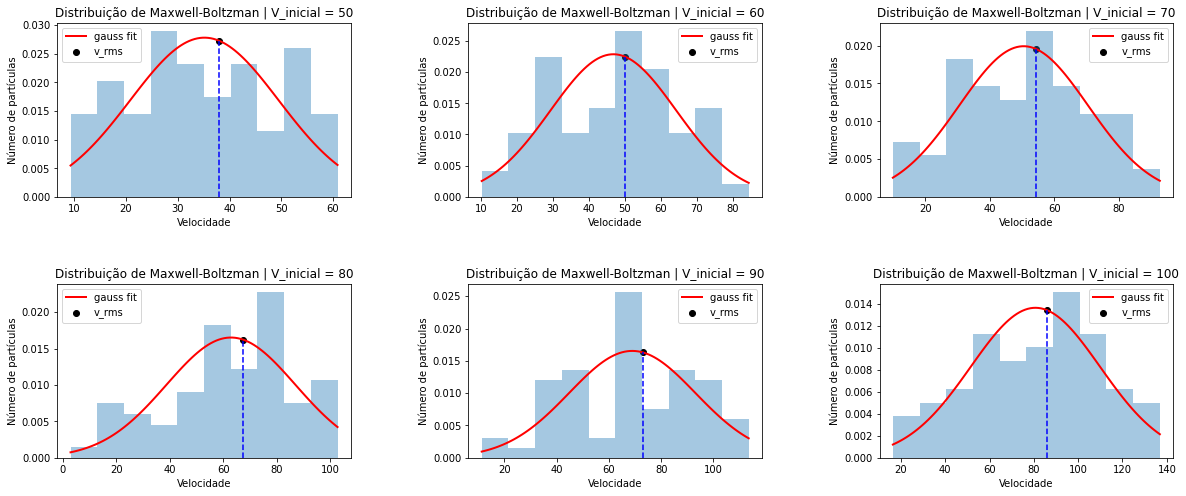

In [12]:
loops = {} # Todas as informações estão aqui. Cada item representa uma velocidade inicial. Dentro das velocidades iniciais, estão
            # os outros dados de antes para uma única simulaçao.
concentracoesA = {}
concentracoesB = {}
tempos = {}
plotar_velocidades = [50, 60, 70, 80, 90, 100,] #mudar aqui para calcular diferentes velocidades
velocidades_medias = []
temperaturas = []

for v_inicial in plotar_velocidades:
    cA = []
    t = []
    cB = []
    evolucao, velocidades_particulas = simulacao(num_atoms, raio, massa, raioB, massaB, dt, v_inicial)
    
    for i in evolucao:
        cA.append(evolucao[i]['A'])
        t.append(evolucao[i]['tempo'])
        cB.append(evolucao[i]['B'])
        
    concentracoesA[f'{v_inicial}'] = cA
    concentracoesB[f'{v_inicial}'] = cB
    tempos[f'{v_inicial}'] = t
    loops[f'{v_inicial}'] = evolucao
    loops[f'{v_inicial}']['velocidades'] = velocidades_particulas
    
    
####### Cálculo da temperatura #######
coluna = 0 # número de colunas no plot do gráfico
linha = 0
tamanho_colunas = len(loops)
tamanho_linhas = round(tamanho_colunas/3)

fig, axs = plt.subplots(2, 3, figsize=(20, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.5)
    
for item in loops:
    if coluna == 3:
        linha = linha + 1
        coluna = 0

    
    quadrado_velocidades = [(velocidade)**2 for velocidade in loops[item]['velocidades']]
    v_rms = np.sqrt(sum(quadrado_velocidades) / len(quadrado_velocidades))
    loops[item]['temperatura'] =  ((v_rms**2)*m)/2*R
    
    print(f"v_inicial = {item} | Temperatura = {loops[item]['temperatura']} K")
    temperaturas.append(loops[item]['temperatura'])
    velocidades_medias.append(np.mean(loops[item]['velocidades']))
    ####### Histograma das velocidades #######
    
    # Ajustar os dados a uma distribuição gaussiana usando a função norm.fit()
    mu, sigma = norm.fit(loops[item]['velocidades'])
    
    # Calcular a distribuição gaussiana ajustada
    x = np.linspace(np.min(loops[item]['velocidades']), np.max(loops[item]['velocidades']), 100)
    normalizado = norm.pdf(x, mu, sigma)
    
    axs[linha, coluna].hist(loops[item]['velocidades'], bins=10, density=True, alpha=0.4)
    axs[linha, coluna].plot(x, normalizado,  color='red',linewidth=2, label = "gauss fit")
    axs[linha, coluna].scatter(v_rms, norm.pdf(v_rms, mu, sigma), color='black', marker='o', label='v_rms')
    axs[linha, coluna].plot([v_rms, v_rms], [0, norm.pdf(v_rms, mu, sigma)], linestyle='--', color='blue')
    axs[linha, coluna].set_xlabel('Velocidade')
    axs[linha, coluna].set_ylabel('Número de partículas')
    axs[linha, coluna].set_title(f'Distribuição de Maxwell-Boltzman | V_inicial = {item}')
    axs[linha, coluna].legend()

    
    coluna=coluna+1
    # Ajuste o layout para evitar sobreposição
    #plt.tight_layout()
    
plt.show()


## Temperatura X Velocidade

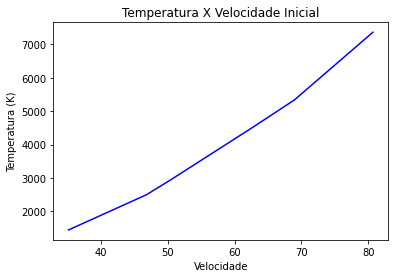

In [13]:
plt.plot(velocidades_medias, temperaturas, color='blue')
plt.xlabel('Velocidade')
plt.ylabel('Temperatura (K)')
plt.title('Temperatura X Velocidade Inicial')
plt.show()

## Taxa de reação k

In [14]:
def decaimento_exponencial(T, concentracao_A0, K):
    return concentracao_A0 * np.exp(-K * T)

Valor de K: 0.045


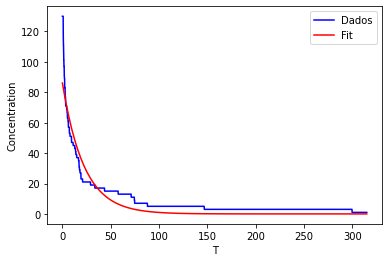

Valor de K: 0.057


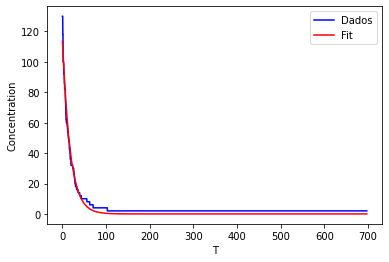

Valor de K: 0.068


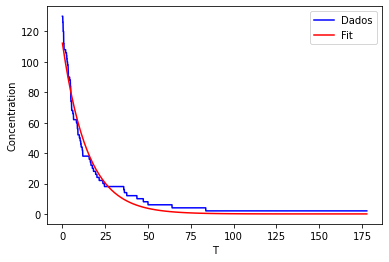

Valor de K: 0.055


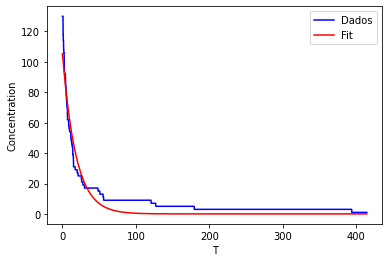

Valor de K: 0.092


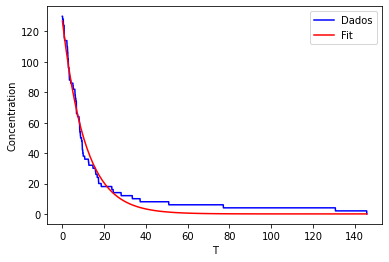

Valor de K: 0.049


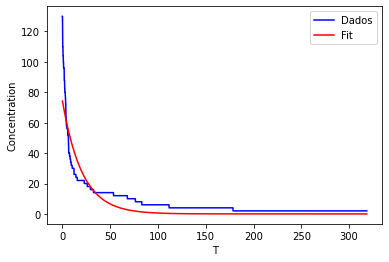

In [15]:
concentracao_A0_inicial = -1000.0  
K_inicial = 0.1 #0.035  
lista_K = []

for item in tempos:
    concentracao_A = concentracoesA[item]
    concentracao_B = concentracoesB[item]
    T = tempos[item]
    model = Model(decaimento_exponencial)

    
    model.set_param_hint('concentracao_A0', value=concentracao_A0_inicial)
    model.set_param_hint('K', value=K_inicial)

    result = model.fit(concentracao_A, T=T, concentracao_A0=concentracao_A0_inicial, K=K_inicial, nan_policy='omit')

    fit_parameters = result.params
    concentracao_A0_fit = fit_parameters['concentracao_A0'].value
    K_fit = fit_parameters['K'].value

    T_fitted = np.linspace(min(T), max(T), 100)
    concentracao_fitted = decaimento_exponencial(T_fitted, concentracao_A0_fit, K_fit)
    
    K = result.params['K'].value
    lista_K.append(K)
    print("Valor de K:", round(K, 3))
    plt.plot(T, concentracao_A, label='Dados', color='b')
    plt.plot(T_fitted, concentracao_fitted, label='Fit', color='r')
    plt.xlabel('T')
    plt.ylabel('Concentration')
    plt.legend()
    plt.show()


## Taxa de reação X Velocidade média

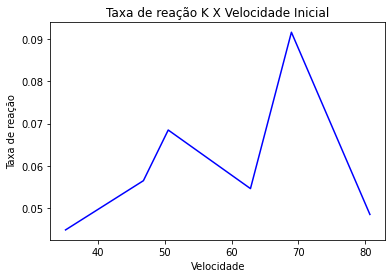

In [16]:
plt.plot(velocidades_medias, lista_K, color='blue')
plt.xlabel('Velocidade')
plt.ylabel('Taxa de reação')
plt.title('Taxa de reação K X Velocidade Inicial')
plt.show()

## Energia de ativação

 $K = Z e^{\frac{-Ea}{RT}}$
 

##### Quero achar Ea, então,

$\frac{K}{Z}= e^{-\frac{Ea}{RT}}$

$log(\frac{K}{Z}) = log(e^{-\frac{Ea}{RT}})$

$log(\frac{K}{Z}) = -\frac{Ea}{RT}log(e)$

$\frac{Ea}{RT} = - log(\frac{K}{Z})$

$Ea = - RT log(\frac{K}{Z})$

##### Encontrar Z (frequência de colisão):

$Z = N_a N_b \sigma \sqrt{\frac{8 k_b T}{\pi \mu}} $

##### como só temos uma única partícula que reage com si mesma para formar uma segunda,

$Z = {N_a}^2 \sigma \sqrt{\frac{8 k_b T}{\pi \mu}} $

##### sendo que $\sigma$ corresponde a sessão transversal de colisão

$\sigma = \pi (r_a+r_b)^2$

##### e, novamente, como só temos um átomo reagindo com ele mesmo,

$\sigma = \pi (r_a)^4$

In [38]:
### Determinando a frequência de colisão e da energia de ativação

kb = 1.38 *10**(-23) #J⋅K −1 (cte de Boltzman)
sigma = np.pi*(raio)**4 #seção transversal
mu = (massa**2)/2*massa #massa reduzida

for j in temperaturas:

    Z = (num_atoms**2)*sigma*np.sqrt((8*kb*j)/(np.pi*mu))
    Ea = -R*j*np.log(K/Z)
    
    print('Ea=', Ea, 'para T=', j,'e Z=', Z)
    print()

Ea= -796.9403343254919 para T= 1441.368064654087 e Z= 4.836638126695482e-05

Ea= -1324.5913870248685 para T= 2494.6985922383906 e Z= 6.363047837620871e-05

Ea= -1547.7699757251487 para T= 2952.502505677537 e Z= 6.922313832469015e-05

Ea= -2296.904981443792 para T= 4529.444386043726 e Z= 8.573903933030147e-05

Ea= -2670.908016454114 para T= 5335.940006591809 e Z= 9.305969318168854e-05

Ea= -3591.174263894556 para T= 7364.019236589148 e Z= 0.00010932351944572033

